# In this project, I will illustrate the connections between the main characters in all 7 Harry Potter books.

In [97]:
import pandas as pd
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import os
import logging
import plotly.express as px
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import re 
import itertools
import matplotlib.pyplot as plt
from itertools import combinations

In [98]:
## Setup chrome options
chrome_options = Options()
chrome_options.add_argument("--headless") # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")

# Silent download of drivers
logging.getLogger('WDM').setLevel(logging.NOTSET)
os.environ['WDM_LOG'] = 'False'

# Create service
webdriver_service = Service(ChromeDriverManager().install())

# Create driver
driver = webdriver.Chrome(service = webdriver_service, options = chrome_options)

# Go to the characters in books page
page_url = "https://harrypotter.fandom.com/wiki/Category:Individuals"
driver.get(page_url)

# Find books
book_categories = driver.find_elements(by=By.CLASS_NAME, value='category-page__member-link')

books = []
for category in book_categories:
    book_url = category.get_attribute('href')
    book_name = category.text
    books.append({'book_name': book_name, "url": book_url})
books

[WDM] - Downloading: 100%|██████████| 6.68M/6.68M [00:00<00:00, 8.03MB/s]


[{'book_name': 'Template:Individual infobox test',
  'url': 'https://harrypotter.fandom.com/wiki/Template:Individual_infobox_test'},
 {'book_name': 'Category:Deceased individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Deceased_individuals'},
 {'book_name': 'Category:Deities',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Deities'},
 {'book_name': 'Category:Disowned individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Disowned_individuals'},
 {'book_name': 'Category:Fictional characters',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Fictional_characters'},
 {'book_name': 'Category:Homosexuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Homosexuals'},
 {'book_name': 'Category:Impersonated individuals',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Impersonated_individuals'},
 {'book_name': 'Category:Individuals by house',
  'url': 'https://harrypotter.fandom.com/wiki/Category:Individuals_by_house'},
 {'book_name':

In [99]:
#getting a character list from every url

character_list = []
for book in books:
    # go to book page
    driver.get(book['url'])
    
    character_elems = driver.find_elements(by=By.CLASS_NAME, value = 'category-page__member-link')
    
    for elem in character_elems:
        character_list.append({'book': book['book_name'],'character': elem.text})

In [114]:
character_df = pd.DataFrame(character_list)

c = character_df['book'].value_counts(ascending=True)

barchart = px.bar(
    data_frame = c, orientation='h')
   
barchart

In [115]:
#data cleaning

#using regex for for removing unwanted parts of the names, lowering the letters, and split columns to a first and last names.
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)).map(lambda x: x.lower()) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])
character_df['character_lastname'] = character_df['character'].str.split()

for count, char in enumerate (character_df['character_lastname']):
    character_df['character_lastname'][count]  = character_df['character_lastname'][count][1:]
character_df['character_lastname'] = character_df['character_lastname'].apply(lambda x: ' '.join(map(str, x)))


#removing outliers manually
remove_list = ['the', 'boy', 'man', 'director', 'first', 'reading','crowd',
               'two', 'day', 'night', 'old', 'five', 'woman', 'young',
              'evil', 'fifty', 'goblet', 'three', 'muggle', 'platform', 'third',
               'wizard', 'evil', 'dragon','mountain','quidditch', 'mother', 'father']

character_df = character_df[~character_df['character_firstname'].isin(remove_list)]
character_df = character_df[~character_df['character_lastname'].isin(remove_list)]

#insert values to cells
character_df.at[595,'character_lastname']= 'dumbledore'
character_df.at[154,'character_firstname']= 'ron'

In [117]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

# Get all book files in the data directory
all_books = [b for b in os.scandir('harry potter text') if '.txt' in b.name]

#Reading .txt data into a variable
def read_book(title_path):
    with open(title_path, "r", encoding ="utf8") as current_file:
        text = current_file.read()
        text = text.replace("\n", "").replace("\r", "")
    return text



In [118]:
#reading the files
book1 = read_book(all_books[0])
book2 = read_book(all_books[1])
book3 = read_book(all_books[2])
book4 = read_book(all_books[3])
book5 = read_book(all_books[4])
book6 = read_book(all_books[5])
book7 = read_book(all_books[6])

#join all book strings as book1
book1 = book1 + book2 + book3 + book4 + book5 + book6 + book7

In [119]:
book1 = book1.replace('Harry Potter and the', '')
book1 = book1.split('.')
book1 = pd.DataFrame(book1)
book1[0] = book1[0].map(lambda x: x.lower())
book1.columns = ['sentences']

#removing page numbers and texts from strings
book1['sentences'] = book1['sentences'].apply(lambda x: re.sub(r"” page \| [0-9]+", "xxxx", x)) 
book1['sentences'] = book1['sentences'].apply(lambda x: re.sub(r"page \| [0-9]+", "xxxx", x)) 
book1 = book1[book1["sentences"].str.contains("xxxx") == False]
book1 = book1.replace(r'^s*$', float('NaN'), regex = True).dropna()
book1['sentences'] = book1['sentences'].str.split() #spliting every sentence to list of words
book1



,sentences
0,"[/, the, boy, who, lived, mr]"
1,"[and, mrs]"
2,"[dursley,, of, number, four,, privet, drive,, ..."
3,"[they, were, the, last, people, you’d, expect,..."
4,[mr]
...,...
97306,"[“i, know, he, will]"
97307,"[”, the, scar, had, not, pained, harry, for, n..."
97308,"[all, was, well]"
97310,[k]


In [120]:
#filtering every sentence and keeping only the characters names
def filter_entity(entity_list, character_df):
    return [ent for ent in entity_list
           if ent in list(character_df['character_firstname'])
           or ent in list(character_df['character'])
           or ent in list(character_df['character_lastname'])]
book1['sentences1'] = book1['sentences'].apply(lambda x: filter_entity(x, character_df))

In [121]:
book1 = book1[book1['sentences1'].map(len) > 0] #filtering rows without names
book1['connections'] = 'NaN'
book1 = book1.reset_index(drop=True)

#runnig window that create a list of all connections with a sentence and the next 2 sentences 
for count, con in enumerate(book1['connections']):
    if count < (len(book1)-2) :
        book1['connections'][count] = list(itertools.chain(book1['sentences1'][count], book1['sentences1'][count+1], book1['sentences1'][count+2]))

#filtering names that return more then once
book1['connections'] = book1['connections'].apply(lambda x: list(set(x))) 
book1 = book1[book1["connections"].apply(len) > 1]
book1 = book1.reset_index(drop=True)
book1

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16820\2931243958.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sentences,sentences1,connections
0,"[dursley, was, thin, and, blonde, and, had, ne...",[dursley],"[potter, dursley]"
1,"[the, dursley, s, had, a, small, son, called, ...",[dursley],"[potter, dursley]"
2,"[potter, was, mrs]",[potter],"[potter, dursley]"
3,"[dursley, arrived, in, the, grunnings, parking...",[dursley],"[harry, dursley]"
4,"[dursley, always, sat, with, his, back, to, th...",[dursley],"[harry, dursley]"
...,...,...,...
28605,"[a, great, number, of, faces,, both, on, the, ...",[harry],"[students, rose, harry, ron, albus]"
28606,"[“why, are, they, all, staring?”, demanded, al...","[albus, rose, students]","[students, rose, harry, ron, albus]"
28607,"[“don’t, let, it, worry, you,”, said, ron]",[ron],"[harry, ron]"
28608,"[as, harry, looked, at, her,, he, lowered, his...",[harry],"[a, N]"


In [122]:
book1 = book1[:-2]

#maching all the possible combinations(without replacement) of connections
book1['connections1'] = book1['connections'].apply(lambda x: list(combinations(x, 2))) 

#Transform each connection of the list to a  new row, replicating index values
book1 = book1.explode('connections1').reset_index(drop=True) 
book1['connections1'] = book1['connections1'].apply(lambda x: list(x))

book1

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16820\2909672511.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sentences,sentences1,connections,connections1
0,"[dursley, was, thin, and, blonde, and, had, ne...",[dursley],"[potter, dursley]","[potter, dursley]"
1,"[the, dursley, s, had, a, small, son, called, ...",[dursley],"[potter, dursley]","[potter, dursley]"
2,"[potter, was, mrs]",[potter],"[potter, dursley]","[potter, dursley]"
3,"[dursley, arrived, in, the, grunnings, parking...",[dursley],"[harry, dursley]","[harry, dursley]"
4,"[dursley, always, sat, with, his, back, to, th...",[dursley],"[harry, dursley]","[harry, dursley]"
...,...,...,...,...
105914,"[“why, are, they, all, staring?”, demanded, al...","[albus, rose, students]","[students, rose, harry, ron, albus]","[rose, albus]"
105915,"[“why, are, they, all, staring?”, demanded, al...","[albus, rose, students]","[students, rose, harry, ron, albus]","[harry, ron]"
105916,"[“why, are, they, all, staring?”, demanded, al...","[albus, rose, students]","[students, rose, harry, ron, albus]","[harry, albus]"
105917,"[“why, are, they, all, staring?”, demanded, al...","[albus, rose, students]","[students, rose, harry, ron, albus]","[ron, albus]"


In [123]:
#spliting the connections names to columns and counting the number of each connection
connections = pd.DataFrame(book1["connections1"].to_list(), columns=['char1', 'char2']) 
connections["value"] = 1
connections = connections.groupby(["char1","char2"], sort=False, as_index=False).sum() #group by connections number
connections = connections.sort_values(by=['value'], ascending=False)
connections = connections.head(300)
connections

,char1,char2,value
293,harry,ron,5498
363,harry,hermione,3650
19,harry,dumbledore,3063
362,hermione,ron,3056
361,hermione,harry,2869
...,...,...,...
691,harry,bloody,50
473,family,hermione,50
1172,weasley,ministry,50
3925,bellatrix,death,49


In [124]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(connections, 
                            source = "char1", 
                            target = "char2", 
                            edge_attr = "value", 
                            create_using = nx.Graph())


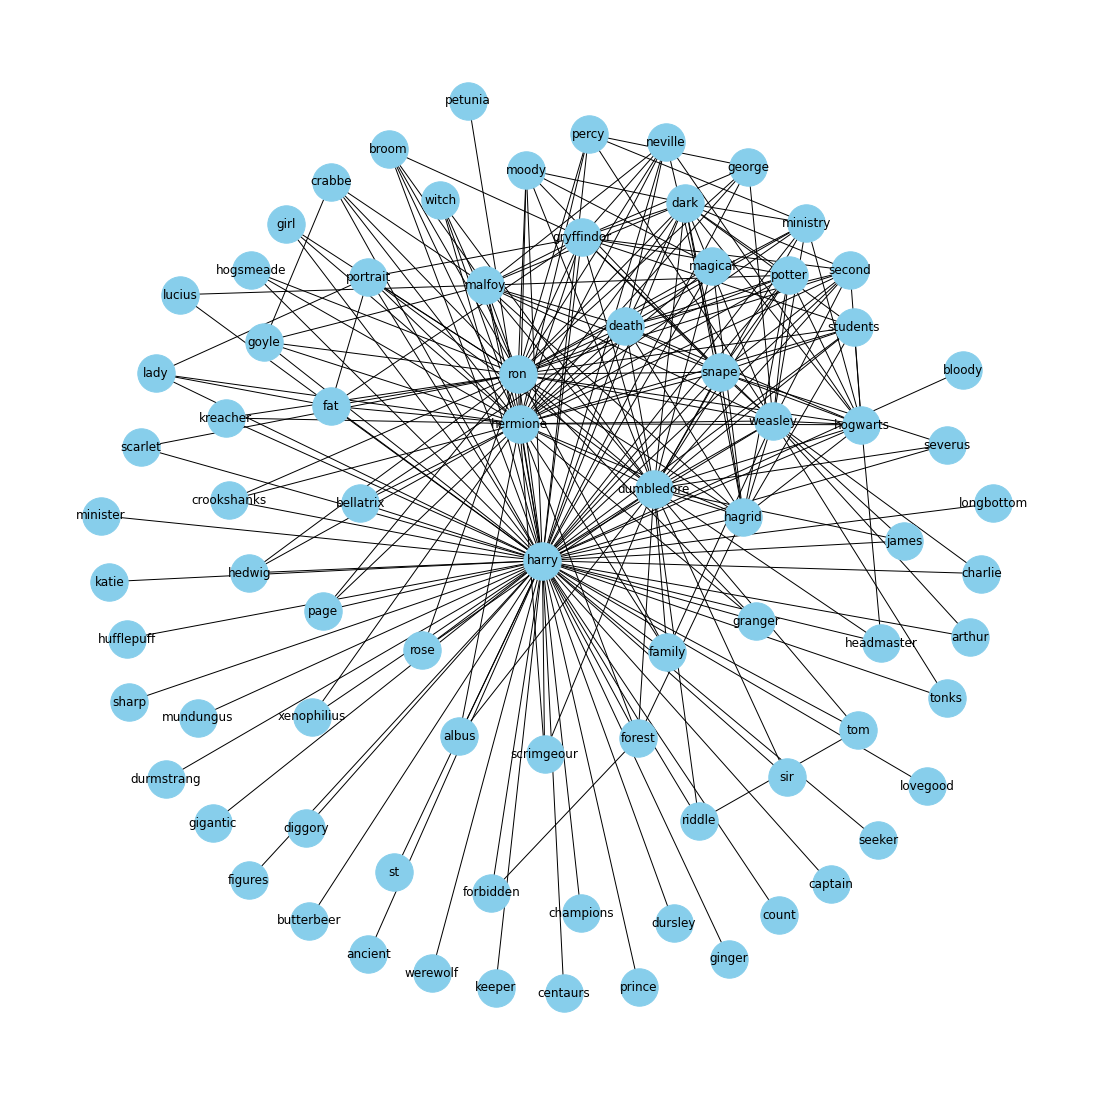

In [125]:
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos, node_size=1400)
plt.show()